# Data import

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("../inputs/loan.csv")

We should specify:

* dates to parse
* proper dtypes
* possible head sampling to go faster

In [ ]:
data.columns[[19, 55]]

In [ ]:
data.columns

In [ ]:
data.last_credit_pull_d.head()

In [ ]:
dates_to_parse = ['earliest_cr_line'] +\
                 [col for col in data.columns if col.endswith('_d')]

dates_to_parse

In [ ]:
dtype = {
    'desc': 'object',
    'verification_status_joint': 'category',
}

dates_to_parse = ['earliest_cr_line',
                  'issue_d',
                  'last_pymnt_d',
                  'next_pymnt_d',
                  'last_credit_pull_d']

data = pd.read_csv("../inputs/loan.csv", dtype=dtype,
                   parse_dates=dates_to_parse)

In [ ]:
data.info()

In [ ]:
data.select_dtypes(include=['object']).nunique()

In [ ]:
count_distinct_series = data.select_dtypes(include=['object']).nunique()

In [ ]:
list(count_distinct_series[count_distinct_series < 20].index)

In [ ]:
dtype = {
    'desc': 'object',
    'verification_status_joint': 'category',
    'grade': 'category',
    'emp_length': 'category',
    'home_ownership': 'category',
    'verification_status': 'category',
    'loan_status': 'category',
    'pymnt_plan': 'category',
    'purpose': 'category',
    'initial_list_status': 'category',
    'application_type': 'category',
}

dates_to_parse = ['earliest_cr_line',
                  'issue_d',
                  'last_pymnt_d',
                  'next_pymnt_d',
                  'last_credit_pull_d']

data = pd.read_csv("../inputs/loan.csv", dtype=dtype,
                   parse_dates=dates_to_parse)

In [ ]:
data['term'].value_counts()

In [ ]:
data['term'].head()

In [ ]:
data.info()

In [ ]:
data['term'].str.extract('(\d+)', expand=False)

In [ ]:
data['term'].apply(lambda x: x.extract('\d+'))

In [ ]:
data = data.assign(term=lambda x: x['term'].str.extract('(\d+)', expand=False).astype(int))

In [ ]:
data.info()

In [ ]:
data = data \
        [
        ((data['loan_status'].isin(['Fully Paid', 'Charged Off'])) &
         (
             ((data['issue_d'] < np.datetime64('2012-06-01')) & (data['term'] == 36)) |
             ((data['issue_d'] < np.datetime64('2010-06-01')) & (data['term'] == 60))
         )
         )
    ]

In [ ]:
(data.loc[data['loan_status'].isin(['Fully Paid', 'Charged Off']), :]
     .loc[])

In [ ]:
import os
import numpy as np
import pandas as pd

def load_data(file_path):
    ''' 
    This function loads at given path.
    Then dates are parsed, categories are casted.
    '''
    dtype = {
    'desc': 'object',
    'verification_status_joint': 'category',
    'grade': 'category',
    'emp_length': 'category',
    'home_ownership': 'category',
    'verification_status': 'category',
    'loan_status': 'category',
    'pymnt_plan': 'category',
    'purpose': 'category',
    'initial_list_status': 'category',
    'application_type': 'category',
    }

    dates_to_parse = [
    'earliest_cr_line',
    'issue_d',
    'last_pymnt_d',
    'next_pymnt_d',
    'last_credit_pull_d'
    ]
    
    data = (pd.read_csv(file_path, dtype=dtype,
                        parse_dates=dates_to_parse)
              .assign(term=lambda x: x['term'].str.extract('(\d+)', 
                      expand=False).astype(int))
              .dropna(axis=1, how='all'))
    
    return(data)

In [ ]:
data = load_data("../inputs/loan.csv")

In [ ]:
data.head()

In [ ]:
def learn_score_split(df):
    '''
    Separate train and score data based on issue_d.
    '''
    closed_short_loans_mask = ((data['issue_d'] < np.datetime64('2012-06-01'))
                               & (data['term'] == 36))
    closed_long_loans_mask = ((data['issue_d'] < np.datetime64('2010-06-01')) 
                               & (data['term'] == 60))
    closed_loans_mask = closed_short_loans_mask | closed_long_loans_mask

    learn_base = df.loc[closed_loans_mask, :].reset_index()
    score_base = df.loc[~ closed_loans_mask, :].reset_index()

    return learn_base, score_base

In [ ]:
learn_base, score_base = learn_score_split(data)

In [ ]:
learn_base.head()

In [ ]:
score_base.head()

In [ ]:
learn_base.to_feather("../inputs/learn_base.feather")

In [ ]:
learn_base.index

In [ ]:
isinstance(learn_base.index, pd.Int64Index)

In [ ]:
learn_base.index.equals(pd.RangeIndex.from_range(range(len(learn_base))))

# Learning

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_feather("../inputs/learn_base.feather")

In [ ]:
train_data.head()

In [ ]:
train_data['loan_status'].value_counts()

In [ ]:
# should I use pandas df.where ?
train_data = train_data.assign(easy_loan_status=np.where(train_data['loan_status'] == 'Fully Paid', 0, 1))

In [ ]:
from sklearn.base import TransformerMixin

In [ ]:
class ColumnSelector(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

In [ ]:
cs = ColumnSelector(['loan_status', 'term'])

In [ ]:
cs.transform(train_data)

In [ ]:
train_data.columns

In [ ]:
list(train_data.select_dtypes(include=['float']).columns)

In [ ]:
columns = list(train_data.select_dtypes(include=['float']).columns)
missing_table = train_data[columns].isnull().sum()
f_columns = list(missing_table[missing_table == 0].index)

In [ ]:
f_columns = ['loan_amnt', 'int_rate', 'installment', 'dti', 'revol_bal']

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
#columns = ['loan_amnt', 'int_rate']
columns = f_columns

rf_pipeline = make_pipeline(
	ColumnSelector(columns),
	RandomForestClassifier(),
	)

In [ ]:
X = train_data.drop(['easy_loan_status'], axis=1)

In [ ]:
y = train_data['easy_loan_status']

In [ ]:
rf_pipeline.fit(X, y)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(rf_pipeline, X, y, scoring='roc_auc', cv=10)

# GOGO LEARN YMTF

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn.externals import joblib

In [2]:
train_data = pd.read_feather("../inputs/learn_base.feather")

In [3]:
train_data['loan_status'].value_counts()

Fully Paid                                             36332
Charged Off                                             4850
Does not meet the credit policy. Status:Fully Paid      1800
Does not meet the credit policy. Status:Charged Off      653
Late (31-120 days)                                         0
Late (16-30 days)                                          0
Issued                                                     0
In Grace Period                                            0
Default                                                    0
Current                                                    0
Name: loan_status, dtype: int64

In [4]:
train_data = train_data.loc[train_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
train_data['loan_status'].value_counts()

Fully Paid                                             36332
Charged Off                                             4850
Late (31-120 days)                                         0
Late (16-30 days)                                          0
Issued                                                     0
In Grace Period                                            0
Does not meet the credit policy. Status:Fully Paid         0
Does not meet the credit policy. Status:Charged Off        0
Default                                                    0
Current                                                    0
Name: loan_status, dtype: int64

In [5]:
train_data = train_data.assign(easy_loan_status=np.where(train_data['loan_status'] == 'Fully Paid', 0, 1))

In [6]:
train_data['desc'].isnull()

0        False
1         True
2        False
3         True
4        False
5         True
6        False
7        False
8         True
9         True
10        True
11       False
12       False
13        True
14       False
15       False
16        True
17        True
18        True
19       False
20        True
21       False
22       False
23       False
24       False
25        True
26       False
27       False
28       False
29       False
         ...  
43605    False
43606     True
43607    False
43608     True
43609     True
43610    False
43611    False
43612     True
43613    False
43614     True
43615    False
43616    False
43617    False
43618    False
43619     True
43620     True
43621    False
43622     True
43623     True
43624    False
43625    False
43626     True
43627     True
43628    False
43629     True
43630    False
43631    False
43632     True
43633     True
43634    False
Name: desc, Length: 41182, dtype: bool

In [7]:
train_data = train_data.assign(has_desc=np.where(train_data['desc'].isnull(), 0, 1))

In [8]:
class ColumnSelector(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns]
    def get_params(self, deep=True):
        return {'columns': self.columns}

In [9]:
train_data = train_data.assign(diff_financed=np.abs(train_data['loan_amnt'] - train_data['funded_amnt']))
train_data = train_data.loc[train_data['diff_financed'] < 1, :]

In [10]:
default_taux = (train_data['easy_loan_status'].sum() / train_data.shape[0]) * 100
print("We have a default rate of {} %".format(default_taux))

We have a default rate of 11.773446593526337 %


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40379 entries, 0 to 43634
Data columns (total 78 columns):
index                          40379 non-null int64
id                             40379 non-null int64
member_id                      40379 non-null int64
loan_amnt                      40379 non-null float64
funded_amnt                    40379 non-null float64
funded_amnt_inv                40379 non-null float64
term                           40379 non-null int32
int_rate                       40379 non-null float64
installment                    40379 non-null float64
grade                          40379 non-null category
sub_grade                      40379 non-null object
emp_title                      37656 non-null object
emp_length                     40379 non-null category
home_ownership                 40379 non-null category
annual_inc                     40379 non-null float64
verification_status            40379 non-null category
issue_d                        40

In [12]:
train_data['purpose'].value_counts()

debt_consolidation    18942
credit_card            6524
other                  3828
home_improvement       2725
major_purchase         2058
small_business         1635
car                    1267
wedding                 941
medical                 702
moving                  587
vacation                408
house                   367
educational             302
renewable_energy         93
Name: purpose, dtype: int64

In [13]:
num_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'has_desc', 'dti', 'delinq_2yrs']
cat_features = ['grade', 'home_ownership', 'verification_status', 'purpose']
all_features = num_features + cat_features

In [14]:
X = train_data.drop(['easy_loan_status'], axis=1)
y = train_data['easy_loan_status']

In [15]:
rf_params = {'n_estimators': 100,
             'max_depth': 5,}

rf_pipeline = make_pipeline(
              ColumnSelector(all_features),
              FunctionTransformer(pd.get_dummies, validate=False, kw_args={'dummy_na': True}),
              Imputer(strategy='median'),
              RandomForestClassifier(**rf_params),
              )

In [16]:
?make_pipeline

In [17]:
rf_pipeline.get_params().keys()

dict_keys(['steps', 'columnselector', 'functiontransformer', 'imputer', 'randomforestclassifier', 'columnselector__columns', 'functiontransformer__accept_sparse', 'functiontransformer__func', 'functiontransformer__inv_kw_args', 'functiontransformer__inverse_func', 'functiontransformer__kw_args', 'functiontransformer__pass_y', 'functiontransformer__validate', 'imputer__axis', 'imputer__copy', 'imputer__missing_values', 'imputer__strategy', 'imputer__verbose', 'randomforestclassifier__bootstrap', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'rando

In [18]:
from sklearn.model_selection import cross_val_predict
?cross_val_predict

In [19]:
cross_val_score(rf_pipeline, X, y, cv=5, scoring='roc_auc')

array([ 0.65683952,  0.67432634,  0.6479206 ,  0.58370742,  0.62534175])

In [20]:
train_data.groupby('purpose').agg({'easy_loan_status': np.mean})

,easy_loan_status
purpose,
car,0.087609
credit_card,0.089669
debt_consolidation,0.121951
educational,0.158940
home_improvement,0.096514
house,0.125341
major_purchase,0.084548
medical,0.145299
moving,0.155026


In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
rf_pipeline.get_params()

{'columnselector': <__main__.ColumnSelector at 0x1fa28f0cb00>,
 'columnselector__columns': ['loan_amnt',
  'int_rate',
  'installment',
  'annual_inc',
  'has_desc',
  'dti',
  'delinq_2yrs',
  'grade',
  'home_ownership',
  'verification_status',
  'purpose'],
 'functiontransformer': FunctionTransformer(accept_sparse=False,
           func=<function get_dummies at 0x000001FA26800620>,
           inv_kw_args=None, inverse_func=None, kw_args={'dummy_na': True},
           pass_y=False, validate=False),
 'functiontransformer__accept_sparse': False,
 'functiontransformer__func': <function pandas.core.reshape.reshape.get_dummies>,
 'functiontransformer__inv_kw_args': None,
 'functiontransformer__inverse_func': None,
 'functiontransformer__kw_args': {'dummy_na': True},
 'functiontransformer__pass_y': False,
 'functiontransformer__validate': False,
 'imputer': Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0),
 'imputer__axis': 0,
 'imputer__copy': True,
 'impute

In [23]:
param_grid = {'randomforestclassifier__n_estimators': [5, 10, 20]}
grid_search = GridSearchCV(rf_pipeline, param_grid=param_grid)

In [24]:
grid_search.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('columnselector', <__main__.ColumnSelector object at 0x000001FA28F0CB00>), ('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_dummies at 0x000001FA26800620>,
          inv_kw_args=None, inverse_func=None, kw_args={'dummy_na': True},
          pass_y...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
grid_search.best_params_

{'randomforestclassifier__n_estimators': 5}

# Plot it sns

In [28]:
full_features = all_features + ['easy_loan_status']

In [30]:
df = train_data.loc[:, full_features]

In [31]:
df.head()

,loan_amnt,int_rate,installment,annual_inc,has_desc,dti,delinq_2yrs,grade,home_ownership,verification_status,purpose,easy_loan_status
0,5000.0,10.65,162.87,24000.0,1,27.65,0.0,B,RENT,Verified,credit_card,0
1,2400.0,15.96,84.33,12252.0,0,8.72,0.0,C,RENT,Not Verified,small_business,0
2,10000.0,13.49,339.31,49200.0,1,20.00,0.0,C,RENT,Source Verified,other,0
3,5000.0,7.90,156.46,36000.0,0,11.20,0.0,A,RENT,Source Verified,wedding,0
4,3000.0,18.64,109.43,48000.0,1,5.35,0.0,E,RENT,Source Verified,car,0


In [32]:
%matplotlib inline

In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i*.5) * (7 - i) * flip)

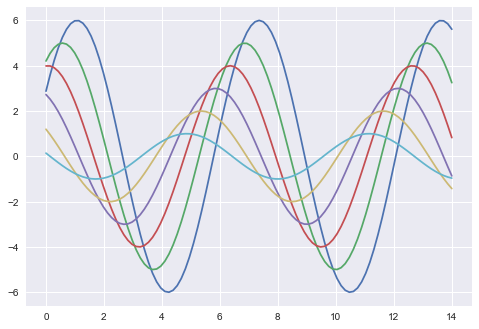

In [35]:
sinplot()

In [36]:
from scipy import stats, integrate
sns.set(color_codes=True)

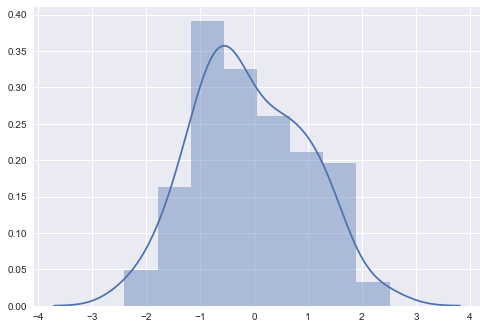

In [37]:
x = np.random.normal(size=100)
sns.distplot(x)

In [38]:
?sns.distplot

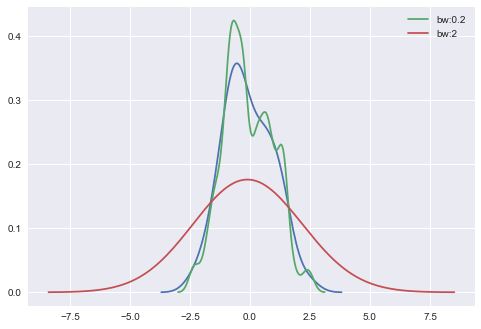

In [39]:
sns.kdeplot(x)
sns.kdeplot(x, bw=.2, label="bw:0.2")
sns.kdeplot(x, bw=2, label="bw:2")
plt.legend()

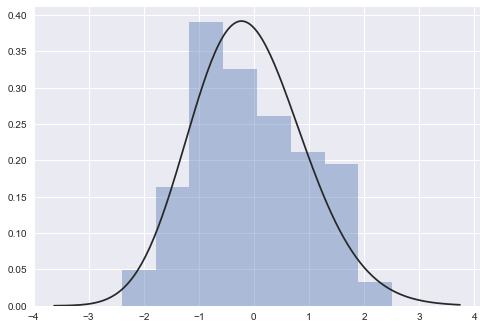

In [40]:
sns.distplot(x, kde=False, fit=stats.gamma)